# IN4080: obligatory assignment 2 (Autumn 2025)
 
Mandatory assignment 2 consists of three parts. In Part 1, you will experiment with a greedy sequence labeling model and investigate the impact of different feature types on **part-of-speech tagging** performance (9 points + 2 optional bonus points). In Part 2, you will evaluate the best model on a different task, **named entity recognition** (5 points). In Part 3, you will return to the **text classification task** and implement a simple feed-forward neural network for it (6 points).

You should answer all three parts. You are required to get at least 12/20 points to pass. The most important is that you try to answer each question (possibly with some mistakes), to help you gain a better and more concrete understanding of the topics covered during the lectures. In the first part, there are also bonus questions for those of you who would like to deepen their understanding of the topics covered by this assignment.

- We assume that you have read and are familiar with IFI’s requirements and guidelines for mandatory assignments, see [here](https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html) and [here](https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-guidelines.html).
- This is an individual assignment. You should not deliver joint submissions. 
- You may redeliver in Devilry before the deadline (__Friday, October 3 at 23:59__), but include all files in the last delivery.
- Only the last delivery will be read! If you deliver more than one file, put them into a zip-archive. You don't have to include in your delivery the files already provided for this assignment. 
- Name your submission _your\_username\_in4080\_mandatory\_2_
- You can work on this assignment either on the IFI machines or on your own computer. 

*The preferred format for the assignment is a completed version of this Jupyter notebook*, containing both your code and explanations about the steps you followed. We want to stress that simply submitting code is __not__ by itself sufficient to complete the assignment - we expect the notebook to also contain explanations of what you have implemented, along with motivations for the choices you made along the way. Preferably use whole sentences, and mathematical formulas if necessary. Explaining in your own words (using concepts we have covered through in the lectures) what you have done and reflecting on your solution is an important part of the learning process - take it seriously!

Regarding the use of LLMs (ChatGPT or similar): you are allowed to use them as 'sparring partner', for instance to clarify something you have not understood. However, you are __not__ allowed to use them to generate solutions (either in part or in full) to the assignment tasks. If you are using code editors such as VS Code, you should make sure that code completion plugins such as Copilot are disabled when working on the assignment.

In this assignment, we'll use the following Python modules: `scikit-learn, pyconll, matplotlib, sentence_transformers`. Make sure you have installed them.

In [ ]:
# if you use a virtual environment, you can install the modules like this
%pip install scikit-learn pyconll matplotlib sentence_transformers

## Part 1 – Greedy logistic regression taggers and feature engineering

In the lecture, we have discussed Matthew Honnibal's proposal of a discriminative sequence labelling model with greedy decoding. He argued that an extended set of features is more helpful for tagging than exact (Viterbi) decoding. Therefore, we skip HMMs and the Viterbi algorithm here and focus on models based on logistic regression.

Scikit-learn doesn't contain implementations of sequence labeling models. Therefore, we provide you with some basic code. The code below defines a `GreedyTagger` with a `fit()` function for training and a `predict()` function for prediction/testing. By default, it uses a standard Scikit-learn logistic regression classifier under the hood, which takes a feature vector for a word (and its context) as input and provides the most likely class label as output.

Your task in this part will mainly consist in defining how a word (and its context) is converted to a feature vector.

In [1]:
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

class GreedyTagger:
    """
        Tagger based on logistic regression or any other classification algorithm supported by Scikit-Learn.
    """

    def __init__(self, feature_function, classifier=LogisticRegression(solver="saga", max_iter=500, tol=0.001)):
        """
            Creates a GreedyTagger object.

            Args:
                feature_function: A function that transforms the input sequence and the index of the current word into a set of key-value pairs.
                classifier: A Scikit-Learn classifier instance.
        """
        self.features = feature_function
        self.classifier = classifier
        self.vectorizer = DictVectorizer()
        self.label_ids = {}     # mapping from labels to numeric label ids
        self.id_labels = {}     # mapping from numeric label ids to labels

    def fit(self, dataset_X, dataset_Y):
        """
            Trains the tagger. Creates a list of inputs (feature vectors of individual words) and a list of labels (numeric ids) and calls the `fit` function of the base classifier on these lists.

            Args:
                dataset_X: The input training data, formatted as a list of lists. Each list item represents a sentence and corresponds to a list of tokens.
                dataset_Y: The training data labels, formatted as a list of lists. Each list item represents a sentence and corresponds to a list of labels (e.g. POS-tags or BIO-tags).
        """
        flattened_dataset_X = []      # a flat list of training instances
        flattened_dataset_Y = []      # a flat list of label ids for the training instances
        for sentence_X, sentence_Y in zip(dataset_X, dataset_Y):
            # sentence_X is a list of words
            # sentence_Y is a list of labels, one for each word of the sentence
            history = []
            for i, (x, y) in enumerate(zip(sentence_X, sentence_Y)):
                feature_dict = self.features(sentence_X, i, history)
                flattened_dataset_X.append(feature_dict)
                if y not in self.label_ids:
                    self.label_ids[y] = len(self.label_ids)
                flattened_dataset_Y.append(self.label_ids[y])
                history.append(y)
        transformed_dataset_X = self.vectorizer.fit_transform(flattened_dataset_X)
        transformed_dataset_Y = np.array(flattened_dataset_Y)
        self.id_labels = {self.label_ids[label]: label for label in self.label_ids}
        self.classifier.fit(transformed_dataset_X, transformed_dataset_Y)
        return self
        
    def predict(self, dataset_X):
        """
            Predicts the labels for the input data, sentence by sentence.

            Args:
                dataset_X: The input training data, formatted as a list of lists. Each list item represents a sentence and corresponds to a list of tokens.
            
            Returns:
                list: The predicted labels, in the same format as dataset_X (list of lists).
        """
        predictions = []
        for sentence_X in dataset_X:
            flattened_sentence_X = []
            history = []
            for i, word in enumerate(sentence_X):
                feature_dict = self.features(sentence_X, i, history)
                flattened_sentence_X.append(feature_dict)
            transformed_sentence_X = self.vectorizer.transform(flattened_sentence_X)
            predicted_sentence_Y = self.classifier.predict(transformed_sentence_X)
            predicted_labels_Y = [self.id_labels[y] for y in predicted_sentence_Y]
            predictions.append(predicted_labels_Y)
        return predictions

When instantiating this class, you need to provide a so-called *feature function* that defines how the feature vector is created. In the provided implementation, this is done in two steps:
1. The feature function creates a feature dictionary. Each key of the dictionary defines a one-hot vector, and the value determines which value of the vector will be set to one. For example, the feature dictionary `{"curr_word": "love", "prev_word": "I", "next_word": "fish"}` defines three one-hot vectors, which together represent the word `love` in the sequence `I love fish`. The keys can be chosen freely.
2. The `DictVectorizer` class of Scikit-Learn will convert the feature dictionary to actual one-hot vectors and concatenate them into a single vector. This step is already taken care of in the `fit()` function.

A basic feature function that only uses the current word could look like this (we will use the parameter `history` later, but don't worry about it now):

In [2]:
def basic_features(sentence, i, history):
    features = {"curr_word": sentence[i]}
    return features

The `predict()` function only returns the predicted labels, it doesn't compare them to the ground truth. Here is another function that computes accuracy for the predictions of a dataset. However, the function is incomplete -- it only uses the first sentence of the dataset.

**Task 1.1** (1 point): Modify the function to take into account all sentences of the dataset. The easiest way to achieve this is to flatten a list of lists into a single list, so you'll only have to call the `accuracy_score` function once.

In [ ]:
"""
def tagging_accuracy(dataset_Y_true, dataset_Y_pred):
    ## CHANGE CODE HERE
    acc = sklearn.metrics.accuracy_score(words_Y_true[0], words_Y_pred[0])
    return acc
"""

In [3]:
# Shu version
def tagging_accuracy(dataset_Y_true, dataset_Y_pred):
    ## CHANGE CODE HERE
    flattened_Y_true = [word for sentence in dataset_Y_true for word in sentence]
    flattened_Y_pred = [word for sentence in dataset_Y_pred for word in sentence]
    acc = sklearn.metrics.accuracy_score(flattened_Y_true, flattened_Y_pred)
    return acc

Shu_solution: 
In the predict function, dataset_X: The input training data, formatted as a list of lists. Each list item represents a sentence and corresponds to a list of tokens. Returns: list: The predicted labels, in the same format as dataset_X (list of lists).
Hint: The easiest way to achieve this is to flatten a list of lists into a single list, so we'll only have to call the accuracy_score function once. I created a small sample code below:

In [4]:
a = [["I","love","fish"],["I","love","cat"]] # example of dataset_X
b = [["PRON","VERB","NOUN"],["PRON","VERB","NOUN"]] # example of dataset_Y_predict and dataset_Y_true
# so we want to turn b into a single list, un-nested the list inside list.

flattened_list = [word for sentence in b for word in sentence]
flattened_list

['PRON', 'VERB', 'NOUN', 'PRON', 'VERB', 'NOUN']

Shu_question:
When we un-nested the list to calculate the accuracy, the accuracy becomes word accuracy. Should we evaluate the accuracy based on word level or sentence level? The granularity will have a very large impact on accuracy. 

Finally, we need some actual data to work with. We provide you with part-of-speech annotated data for Norwegian Bokmål taken from (https://universaldependencies.org/). To load the data, you can use the `pyconll` library:

In [5]:
import pyconll

def load_data(filename):
    data = pyconll.load_from_file(filename)
    X, Y = [], []
    for sentence in data:
        X.append([token.form for token in sentence])	# the "form" field contains the words
        Y.append([token.upos for token in sentence])	# the "upos" field contains the part-of-speech tags in universal POS format
    print(f"{len(X)} sentences loaded from file {filename}")
    return X, Y

train_data_x, train_data_y = load_data('no_bokmaal-ud-train.conllu')
valid_data_x, valid_data_y = load_data('no_bokmaal-ud-dev.conllu')
test_data_x, test_data_y = load_data('no_bokmaal-ud-test.conllu')

15696 sentences loaded from file no_bokmaal-ud-train.conllu
2409 sentences loaded from file no_bokmaal-ud-dev.conllu
1939 sentences loaded from file no_bokmaal-ud-test.conllu


Now, we can put everything together. Let us train a tagger on the training data and evaluate it on the validation set.

**Task 1.2** (1 point): Write the corresponding code and output the accuracy (as a number between 0 and 1).

In [ ]:
#initialize the class
#tagger = GreedyTagger(basic_features)

In [ ]:
#train a tagger on the training data
#tagger.fit(train_data_x, train_data_y)

In [ ]:
#predict on the validation set
#valid_data_y_pred = tagger.predict(valid_data_x)

In [ ]:
#calculate the accuracy on the validation set
# tag_acc = tagging_accuracy(valid_data_y,valid_data_y_pred)
# tag_acc

In [7]:
def model_accuracy(model_name,feature_function):
    tagger = GreedyTagger(feature_function)
    tagger.fit(train_data_x, train_data_y)
    valid_data_y_pred=tagger.predict(valid_data_x)
    tag_acc = tagging_accuracy(valid_data_y,valid_data_y_pred)
    return (model_name, tag_acc)

In [8]:
model_accuracy("basic_features",basic_features)

('basic_features', 0.8853694080123182)

**Task 1.3** (1 point): The basic feature function only looks at the current word. Also add the previous word, the next word, and the word before the previous one. Make sure to handle edge cases at the beginning and at the end of the sentence. For example, the feature dictionary for the first word of `I love fish` could look as follows: `{"curr_word": "I", "prev_word": "<START>", "prev2_word": "<START>", "next_word": "love"}` (you should still not need the parameter `history` for this). Add one feature at a time, train a model, and record the accuracy. Describe which combination of features works best.

Shu_solution:
We refer to the basic_feature structure and form the structure considering ngram. The task requests to consider handling of edge cases both at beginning and end of sentence. So we will use labels "<START>" and "<END>" to mark sentence beginning and end respectively. 
Here we use the condition statement for keys which may need to add "<START>" or "<END>" labels. And run a little test samples. 

In [9]:
s = ["I","love","fish"]
#basic_features(s,0,[])

In [10]:
def context_features(sentence, i, history):

    features = {"curr_word": sentence[i],
                "prev_word": sentence[i-1] if i>=1 else "<START>",
                "prev2_word": sentence[i-2] if i>=2 else "<START>",
                "next_word": sentence[i+1] if i<len(sentence)-1 else "<END>"
               }
    return features

In [11]:
print(context_features(s,0,[]), context_features(s,2,[]))

{'curr_word': 'I', 'prev_word': '<START>', 'prev2_word': '<START>', 'next_word': 'love'} {'curr_word': 'fish', 'prev_word': 'love', 'prev2_word': 'I', 'next_word': '<END>'}


In [12]:
model_accuracy("context_features",context_features)

('context_features', 0.9224889328823999)

Shu explanation:
This task ask for adding one feature at a time, train a model and record the accuracy. 
So we construct the function as follows:
def basic_features --> keys["curr_word"]
def bi_features --> keys["curr_word","prev_word"]
def tri_features --> keys["curr_word","pre_word","next_word"]
def context_features --> keys["curr_word","pre_word","pre2_word","next_word"]

I rapped the task 1 in a func (model_accuracy) so that it can be reused.

In [13]:
# bi_features
def bi_features(sentence, i, history):
    features = {"curr_word": sentence[i],
                "prev_word": sentence[i-1] if i>=1 else "<START>"
               }
    return features
model_accuracy("bi_features",bi_features)

('bi_features', 0.9025268772856003)

In [14]:
# tri_features
def tri_features(sentence, i, history):
    features = {"curr_word": sentence[i],
                "prev_word": sentence[i-1] if i>=1 else "<START>",
                "next_word": sentence[i+1] if i<len(sentence)-1 else "<END>"
               }
    return features
model_accuracy("tri_features",tri_features)

('tri_features', 0.922516428826748)

Shu_conclude:
tri_features --> keys["curr_word","pre_word","next_word"] has the highest accuracy. 

**Task 1.4** (1 point): Up to now, we are still using a unigram model, in the sense that no information about the *labels* at previous positions is incorporated. Let us change this now by adding so-called *transition features*. Add a key `prev_tag` to the feature function and fill it with the label of the previous position. You can use the `history` parameter for this. Write your new feature function below:

Shu_solution:
history is a list to install the prev_word label, so we can simply use history[-1] to get the last label. We need to conside the beginning position where no prev_tag is available, and in this case we add "<START>"

In [15]:
def transition_features(sentence, i, history):
    features = {"curr_word": sentence[i],
                "prev_word": sentence[i-1] if i>=1 else "<START>",
                "next_word": sentence[i+1] if i<len(sentence)-1 else "<END>",
                "prev_tag": history[-1] if i>=1 else "<START>"
               }
    return features

Before you start training the model with the transition features, have a closer look at the starter code provided at the beginning. You will notice that the `history` parameter is correctly filled in the `fit()` function, but that it always remains empty in the `predict()` function. With this setup, adding transition features will not have any impact on the accuracy. You will therefore have to implement an alternative prediction function that fixes this issue.

**Task 1.5** (2 points): Complete the `predict_with_history()` function below such that the history list is filled with the predicted label at each step. Instead of calling `self.classifier.predict()` once per sentence, you will have to call it for each word separately, because the feature vector for a given position can only be computed once the previous word has been labeled.

In [16]:
def predict_with_history(self, dataset_X):

        predict_with_history = []
    
        for sentence_X in dataset_X:
            sentence_pred = []
            history = []
            for i, word in enumerate(sentence_X):
                feature_dict = self.features(sentence_X, i, history)

                #vectorize single sample, not sentence.
                X_i = self.vectorizer.transform([feature_dict])

                #predict y_pred_id based on X_i
                #caution: predict result is an array, we need to exact the y_pred_id, so extract the 1st and the only element. 
                y_pred_id = self.classifier.predict(X_i)[0]

                #get y_pred label
                y_pred = self.id_labels[y_pred_id]

                #update to the history list
                history.append(y_pred)

                #update sentence_pred
                sentence_pred.append(y_pred)
            
            predict_with_history.append(sentence_pred)
            
    
        return predict_with_history

# attach the function to the GreedyTagger class
setattr(GreedyTagger, 'predict_with_history', predict_with_history)

Shu_solution:
Following the hint"Instead of calling self.classifier.predict() once per sentence, you will have to call it for each word separately". This is a greedy prediction strategy. I then construct the vectorizer on word-level X_i instead of on the flattened sentence level. For each token, predict the label_id (y_pred_id) and then convert it into the corresponding label str. This predicted label is appended to the history list so that subsequent predictions can make use of the prev_tag feature. Each predicted part-of-speech tag is added to the current sentence’s prediction, and finally all sentence-level predictions are aggregated into the overall predict_with_history result.

**Task 1.6** (1 point): Train a new tagger using the transition features and the `predict_with_history()` function. Do the transition features help? Note: The prediction will be significantly slower than before because of the modifications made above.

In [17]:
#initialize the class object, input function use transition_features.
tagger = GreedyTagger(transition_features)

In [18]:
#train the model
tagger.fit(train_data_x, train_data_y)

In [20]:
#use the predict_with_history here instead of predict
valid_data_y_pred=tagger.predict_with_history(valid_data_x)

In [21]:
#calculate the accuracy using the transition_feature
tag_acc = tagging_accuracy(valid_data_y,valid_data_y_pred)

Shu_explanation:
During training, the fit() function has access to the gold labels. These are used to fill the history feature, so the model always is on the correct previous tags. However, during prediction the gold labels are not available — the test set has gold labels, but they are hidden from the model and only used for evaluation. Therefore, the predict_with_history() function must rely on the predicted labels to fill the history.

We introduce the prev_tag in the features, this create a dependancy where the predicted tag becomes the input for the next prediction. If we compare this with ML, basically, we predict one data at a time, and use this data as the next prediction's input. We can easily see that the downside is that it will amplify error through propagation. 

**Task 1.7** (_optional, 2 extra points_): You may have noticed that there is a significant implementation difference between the `fit()` and `predict_with_history()` functions. During training, the `history` list is filled with the *gold* labels directly taken from the annotated training data. During prediction, the gold labels are not available, so we have to resort to the *predicted* labels. Could this approach lead to any problems? If so, how could it be improved? 

Shu_explain:
If we think of the model behind these tasks, we can see that task1.1--task1.3 is using greedy logistic regression. Task1.4--task1.6 is using the greedy decoding. I have explained in Task 1.6 that the greedy strategy suffers from error propagation, where early mistakes are amplified in later predictions. To address this issue, I suggest using the Viterbi algorithm instead of greedy decoding, since Viterbi searches for the best overall sequence rather than only the best next move.
Viterbi decoding: The labels are only predicted after reaching the end of the sentence. This is known as CRF layer(conditional random field) in discriminative models. The probability distribution over labels at the previous position is taken into account when computing current label probabilities.
But there is also some downside of CRF due to large computation. MEMM could also be a choice. Maximum Entropy Markov Models are a simpler alternative to CRFs. It computes the 𝑍 normalization term per word instead of per sentence. It is more efficient to train, but less performant.

**Task 1.8** (_optional, 2 extra points_): Take the currently best-performing feature function and add even more features to get an even better tagger. Some ideas:
- Extract suffixes and prefixes of $n$ characters ($1 \leq n \leq 4$) from the current, previous or next word.
- Is the current word a number?
- Is it capitalized?
- Does it contain capitals?
- Does it contain a hyphen? etc.

What is the best feature set you can come up with? Define various feature sets and select the best one based on validation set accuracy.
If you use sources for finding tips about good features (like articles, web pages, etc.) make references to the sources and explain what you got from them.

Up to now, we have been working on the development set. It is time now to evaluate your best-performing model on the held-out test set.

**Task 1.9** (2 points): First, compute the *test set accuracy* of your best model. However, the accuracy only gives us a high-level overview of the performance of a tagger, but we may be interested in finding out more details about where the tagger makes the mistakes. The universal tagset is reasonably small, so we can produce a *confusion matrix*. Take a look at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html and generate a confusion matrix for the results. Which pairs of tags are most easily confounded? You can find the documentation of the tagset in the following link: https://universaldependencies.org/u/pos/index.html

Shu_explain:
We will choose transition_features to test set. We calculate the accuracy. But accuracy would not perform well on unbalanced data. Here we produce the confusioin matrix to display so that we can understand where the mistakes lie. 

In [25]:
#use test data
test_data_y_pred=tagger.predict_with_history(test_data_x)

In [27]:
#calculate accuracy:
tag_acc_test = tagging_accuracy(test_data_y,test_data_y_pred)
tag_acc_test

0.9105653073483281

In [28]:
flattened_y_true = [tag for sent in test_data_y for tag in sent]
flattened_y_pred = [tag for sent in test_data_y_pred for tag in sent]

In [30]:
#calculate the confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = sorted(list(set(flattened_y_true)))
cm = confusion_matrix(flattened_y_true, flattened_y_pred, labels=labels)
cm

array([[2070,    0,    5,    2,    0,    5,    0,  258,    0,    0,    0,
          26,    0,    0,    0,   84,    0],
       [   3, 3632,   47,    0,    0,    1,    0,   14,    0,    0,    0,
           2,    0,   57,    0,   17,    0],
       [   5,   87, 1054,    0,    0,    4,    0,   39,    0,    0,    1,
           3,    0,   10,    0,   17,    0],
       [   0,    0,    0, 1646,    0,    0,    0,    0,    0,    0,    0,
           1,    0,    0,    0,   76,    0],
       [   1,   13,    6,    0,  981,    0,    0,    0,    0,    0,    0,
           1,    0,    0,    0,    1,    0],
       [   4,    1,    8,    0,    0, 1240,    0,    3,    0,    0,   47,
           6,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,   11,   10,    0,    0,    0,
           1,    0,    0,    0,    0,    0],
       [  67,    0,    3,    1,    0,    1,    0, 5168,    0,    0,    3,
          80,    0,    0,    0,  154,    0],
       [  16,    0,    0,    0,    0,    0,    0

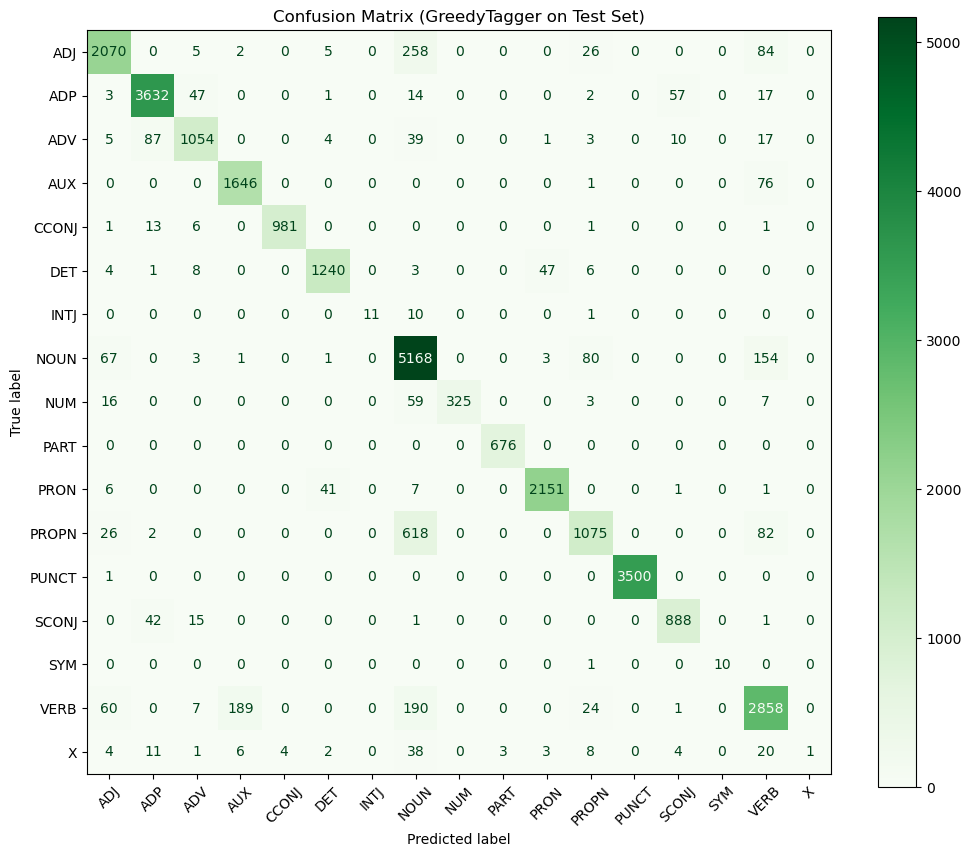

In [33]:
# data visualization using heatmap

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax=ax, cmap="Greens", xticks_rotation=45, colorbar=True)
plt.title("Confusion Matrix (GreedyTagger on Test Set)")
plt.show()

Shu_explain:
We can clearly see that PROPN and NOUN are the most frequently confounded by the model. This is reasonable, since proper nouns often share the same surface forms as common nouns, and the distinction between them depends heavily on context.

## Part 2 – Span identification with sequence models

In this part, you'll use the same sequence models for a different task: named entity recognition for English. 

**Task 2.1** (0.5 point): Write the code to load the train and test data.

Shu_solution:
We first observe the data:

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

1. Each word has one line with a word, followed with labels, the BIO label is the last label, and the delimiter is " "(space)
2. Each sentence is separated with an empty line.

Solution:
1. We first read the txt file.
2. Data preprocessing, we need to hop the first two lines. We need to remove the leading/trailing whitespace characters such as \n
3. We can iterate over each line, if line is not empty Then append the word to word[], until meeting the empty line. When one word list is completed, nested it to sentence[]. Basically the x_data should look like this:
[["EU","rejects","German","call","to","boycott","British","lamb","."],...]
4. The y_data is the label data, here we will use BIO encoding which is that last label.

In [52]:
with open("ner-train.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    print(type(lines))

<class 'list'>


In [53]:
print(lines[:5])

['-DOCSTART- -X- -X- O\n', '\n', 'EU NNP B-NP B-ORG\n', 'rejects VBZ B-VP O\n', 'German JJ B-NP B-MISC\n']


We don't need the first two lines. We can simply start the iteration from 2, remove 0, 1. 

In [56]:
word=[]
tag=[]

for line in lines[2:5]:
    if line:
        line = line.strip()
        elements = line.split()
        word.append(elements[0])
        tag.append(elements[-1])
print(word, tag)

['EU', 'rejects', 'German'] ['B-ORG', 'O', 'B-MISC']


In [68]:
sentence_x=[]
label_y=[]
word=[]
tag=[]

for line in lines[2:20]:
    line = line.strip()
    if line:       
        elements = line.split()
        word.append(elements[0])
        tag.append(elements[-1])
    else:
        if word:
            sentence_x.append(word)
            label_y.append(tag)
            word, tag = [], []
if word: # in case the last line is not empty
    sentence_x.append(word)
    label_y.append(tag)
        
print(sentence_x, label_y)

[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], ['Peter', 'Blackburn'], ['BRUSSELS', '1996-08-22'], ['The', 'European']] [['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'], ['B-PER', 'I-PER'], ['B-LOC', 'O'], ['O', 'B-ORG']]


In [70]:
def load_ner_data(filename):
    # IMPLEMENT THE CODE TO LOAD THE NER DATA

    sentence_x=[]
    label_y=[]
    word=[]
    tag=[]

    with open(filename, "r", encoding="utf-8") as f:
        lines = f.readlines()
        for line in lines[2:]:
            line = line.strip()
            if line:       
                elements = line.split()
                word.append(elements[0])
                tag.append(elements[-1])
            else:
                if word:
                    sentence_x.append(word)
                    label_y.append(tag)
                    word, tag = [], []
        if word: 
            sentence_x.append(word)
            label_y.append(tag)
    return sentence_x, label_y
        
    
train_nerdata_x, train_nerdata_y = load_ner_data('ner-train.txt')
test_nerdata_x, test_nerdata_y = load_ner_data('ner-test.txt')

**Task 2.2** (0.5 point): Train a greedy tagger with the NER training data. Use any feature set that worked well for POS tagging, but *do not include transition features* for now. Compute the token-level accuracy of the test set, as before.

Shu_solution:
According to the task requirement, we can use tri_features. Here for now we do not include transition features. This means we should use predict not predict_with_history. 

In [72]:
tagger = GreedyTagger(tri_features)
tagger.fit(train_nerdata_x, train_nerdata_y)
test_nerdata_y_pred = tagger.predict(test_nerdata_x)

In [73]:
#calculate the accuracy:
acc_tri_ner = tagging_accuracy(test_nerdata_y,test_nerdata_y_pred)
acc_tri_ner

0.9229615343405122

**Task 2.3** (1 point): Token-level accuracy is not well adapted to span identification tasks (why?). Instead, we want to compute precision, recall and f-score of the *entities*. Adapt the code below:

In [74]:
def get_ranges(l):
    """
        Helper procedure for eval_ner.
        You're not expected to change anything here.
    """
    elements = []
    current_element = None
    current_start = None
    for i, ll in enumerate(l):
        if ll == 'O':
            if current_element != None:
                elements.append((current_element, current_start, i))
            current_element = None
            current_start = -1
        elif ll[0] == 'B':
            if current_element != None:
                elements.append((current_element, current_start, i))
            current_element = ll[2:]
            current_start = i
        elif ll[0] == "I":
            if current_element != ll[2:]:
                elements.append((current_element, current_start, i))
                current_element = ll[2:]
                current_start = i
    return elements

def eval_ner(sys_labels, gold_labels):
    """
        Computes precision, recall and f1-score, using get_ranges() to identify the named entities.
    """
    tp, fp, fn = 0, 0, 0
    for sys_l, gold_l in zip(sys_labels, gold_labels):
        sys_ranges = get_ranges(sys_l)
        gold_ranges = get_ranges(gold_l)
        for r in sys_ranges:
            if r in gold_ranges:
                tp += 1
        ## TODO: also count fp and fn
            else:
                fp +=1
        for r in gold_ranges:
            if r not in sys_ranges:
                fn +=1
    
    recall = tp/(tp+fn)
    prec = tp/(tp+fp)
    f1score = 2*prec*recall/(prec+recall)
    ## TODO: compute recall, precision and f1-score from tp, fp and fn

    return recall, prec, f1score

Report precision, recall and f1-score of the model trained above.

Shu_solution:
1. Token-level accuracy is not well adapted to span identification tasks (why?)
This is related to Shu_question in Task1.1. NER involves span identification, it requires the model not only predict the right token class but also the correct boundary.
For example, if gold label is ["B-PER", "I-PER", "I-PER"], the prediction is ["B-PER", "I-PER", "O"], if we look at the token level, the accuracy is 67%, but if we look at the span level, the accuracy is 0. Huge difference.
2. we need to construct fp(false positive) and fn(false negative)
   fp(false positive) means r in sys_ranges but not in gold_ranges
   fn(false negative) means r not in sys_ranges but in gold_ranges
3. construct recall,precision,f1score
   recall = TP/(TP+FN)
   precision = TP/(TP+FP)
   f1score = 2*precision*recall/(precision+recall)

In [75]:
eval_ner(test_nerdata_y_pred,test_nerdata_y)

(0.5313815187557182, 0.6858762399622107, 0.5988246210949582)

Shu_explaination:
Accuracy works well with balanced data, but for unbalanced tasks like NER, most tokens are labeled as “O”, so token-level accuracy can be misleading. In such cases, we are more interested in where the mistakes lie. Hence, introducing precision, recall, and F1-score provides a better understanding of model performance.
The results show that precision > recall, which means there are fewer false positives (FP) than false negatives (FN). In other words, the model is somewhat conservative: it rarely predicts an entity unless it is confident, but it also misses many gold entities.
The F1-score balances precision and recall, and we can clearly see that F1 is much lower compared to token-level accuracy (almost 60% vs 92%). This highlights that while the model seems good at the token level, it struggles to identify complete entity spans.

**Task 2.4** (1 point): Train a new model with transition features and predict the development set labels using `predict_with_history`. How does this change affect the token-level (accuracy) and entity-level (recall, precision, f1-score) metrics?

In [77]:
tagger = GreedyTagger(transition_features)
tagger.fit(train_nerdata_x, train_nerdata_y)
test_nerdata_y_pred_tran = tagger.predict_with_history(test_nerdata_x)
acc_tran_ner = tagging_accuracy(test_nerdata_y,test_nerdata_y_pred_tran)

In [79]:
acc_tran_ner

0.9213757634201222

In [78]:
eval_ner(test_nerdata_y_pred_tran,test_nerdata_y)

(0.5590118938700823, 0.8718607305936074, 0.6812353662615677)

Shu_explaination:
We observe a slight drop in token-level accuracy, but precision, recall, and F1-score all improve — in particular, precision increases significantly (from 68% to 87%). This indicates that the transition-based model produces fewer false positives, which directly contributes to a higher F1-score (from 60% to 68%).

This demonstrates the effect of introducing the prev_tag as a transition feature: it creates a dependency between consecutive tags, which helps the model produce more coherent label sequences. As a result, the predictions better capture complete entity spans, even if the token-level accuracy is slightly lower.

**Task 2.5** (2 points): Take some 50 sentences from the test set and display the words, gold tags, and the predicted tags of the two systems. Can you identify error patterns that are typical for the two systems respectively?

In [80]:
for i in range(50):
    print("Sentence:", " ".join(test_nerdata_x[i]))
    print("Gold:     ", test_nerdata_y[i])
    print("Baseline: ", test_nerdata_y_pred[i])
    print("Trans:    ", test_nerdata_y_pred_tran[i])
    print()

Sentence: SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .
Gold:      ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']
Baseline:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Trans:     ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Sentence: Nadim Ladki
Gold:      ['B-PER', 'I-PER']
Baseline:  ['O', 'O']
Trans:     ['O', 'O']

Sentence: AL-AIN , United Arab Emirates 1996-12-06
Gold:      ['B-LOC', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'O']
Baseline:  ['O', 'O', 'B-LOC', 'I-LOC', 'O', 'O']
Trans:     ['O', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'O']

Sentence: Japan began the defence of their Asian Cup title with a lucky 2-1 win against Syria in a Group C championship match on Friday .
Gold:      ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Baseline:  ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B

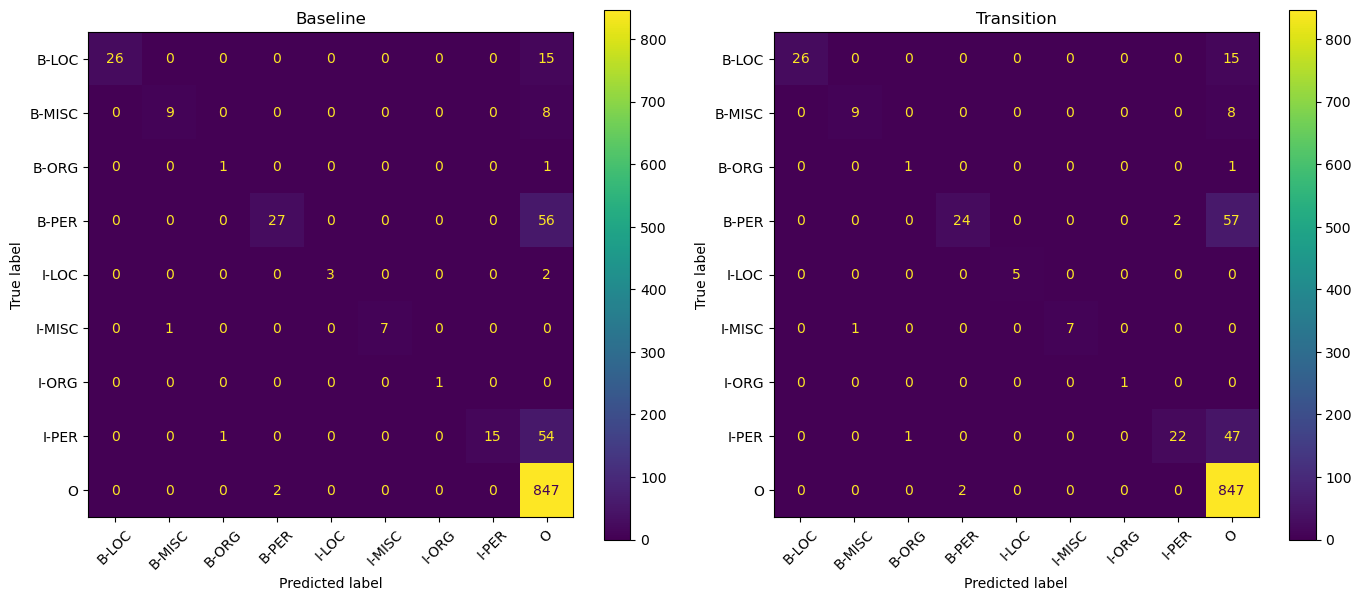

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = [tag for sent in test_nerdata_y[:50] for tag in sent]
y_pred = [tag for sent in test_nerdata_y_pred[:50] for tag in sent]
y_pred_tran = [tag for sent in test_nerdata_y_pred_tran[:50] for tag in sent]

labels = sorted(list(set(y_true)))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm = confusion_matrix(y_true, y_pred, labels=labels)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(ax=axes[0], xticks_rotation=45)
axes[0].set_title("Baseline")

cm_tran = confusion_matrix(y_true, y_pred_tran, labels=labels)
ConfusionMatrixDisplay(confusion_matrix=cm_tran, display_labels=labels).plot(ax=axes[1], xticks_rotation=45)
axes[1].set_title("Transition")

plt.tight_layout()
plt.show()

Shu_explaination:
Baseline:
The major issue is that PER entities are frequently missed, often being predicted as O. This is especially severe for  B-PER and I-PER, which causes person-name spans to inaccurate.
LOC entities also suffer from frequent omissions, indicating low recall for location mentions.

Transition model:
The model has the same major issue as Baseline in PER entities recognition. But it improved in I-PER, indicating that with prev_tag, it helps to better recognise the boundary of an entity. 


## Part 3: Text classification with feed-forward neural networks

For this part, we go back to the text classification task used in the first assignment: language identification of Bokmål and Nynorsk.

Instead of manually creating a bag-of-subwords matrix with the BPE-encoded data, we go a simpler route this time and use the `CountVectorizer` class provided by Scikit-Learn. Have a look at the documentation of `CountVectorizer` here: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

With the default parameters, `CountVectorizer` will tokenize the data at whitespaces, remove punctuation signs and convert everything to lowercase. You can play around with the parameters if you wish, but the default settings work decently well. A useful thing to make the vectors smaller is to remove hapaxes, i.e. words that occur only once in the training data. You can achieve this with `min_df=2`.

**Task 3.1** (2 points): Write the code to produce `train_X, train_Y, test_X, test_Y`. Each `*_X` variable should contain a list of vectors produced by `CountVectorizer`. Each `*_Y` variable should contain a list of integers (1 for Nynorsk and 0 for Bokmål).

In [83]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=2)

In [98]:
# read training data ndt_train_class.txt
import pandas as pd
with open('../oblig1/ndt_train_class.txt', 'r', encoding='utf-8-sig') as f:
  text = f.read()
b = [sent.split('\t') for sent in text.split('\n')]
df_train =  pd.DataFrame(data=b,columns=['instances','label'])
df_train.dropna(inplace=True)
df_train["class"] = df_train["label"].map({"nob": 0, "nno": 1}).astype(int)
df_train

,instances,label,class
0,Jeg husker også Jens Stoltenbergs uttalelse ti...,nob,0
1,"Jeg har fulgt med i mange år, og ikke sett noe...",nob,0
2,Folk i Albania er stolte over NATO-medlemskapet.,nob,0
3,Spesielt i Lindesnes og Lyngdal er det svært m...,nob,0
4,"""Om ikkje det er ein mannleg ønskedraum, så ve...",nno,1
...,...,...,...
29900,Broren John har selv vært rammet av kontroverser.,nob,0
29901,Libero er ikke alene om å pushe ensidig baby- ...,nob,0
29902,"Legg appelsinsteinane i eit klede, og knyt att...",nno,1
29903,Dette er boka om Jerusalem som eg alltid har h...,nno,1


In [112]:
train_X=vectorizer.fit_transform(df_train["instances"]).toarray()
train_Y=df_train["class"].tolist()
len(vectorizer.vocabulary_)

20629

In [103]:
# read test data
with open('../oblig1/ndt_test_class.txt', 'r', encoding='utf-8-sig') as f:
  text = f.read()
b = [sent.split('\t') for sent in text.split('\n')]
df_test =  pd.DataFrame(data=b,columns=['instances','label'])
df_test.dropna(inplace=True)
df_test["class"] = df_test["label"].map({"nob": 0, "nno": 1}).astype(int)
df_test

,instances,label,class
0,- Skamslått etter å ha snakket om innvandrings...,nob,0
1,Det er altfor mye byråkrati til at det er verd...,nob,0
2,Det er rett og slett romantisk.,nob,0
3,Det har allereie gitt resultat:,nno,1
4,Bar med seg båten til 1295 meter over havet.,nno,1
...,...,...,...
7710,Ein moderne språkpolitikk vil med andre ord ve...,nno,1
7711,Tilskuddsordningen skal automatisk tre i kraft...,nob,0
7712,Når barna har blitt 14 - 15 år er så mykje prø...,nno,1
7713,I vedtektene frå 2006 er då også forvaltning a...,nno,1


In [113]:
test_X = vectorizer.transform(df_test["instances"]).toarray()
test_Y = df_test["class"].tolist()

**Task 3.2** (1 point): Create a logistic regression classifier, train it on the training set, and predict the labels of the test set. Compute accuracy, precision and recall, as in the previous assignment. How do your results compare with the previous assignment?

In [114]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver="liblinear", random_state=0)
clf.fit(train_X, train_Y)
test_Y_pred = clf.predict(test_X)

In [120]:
#calculate accuracy, precision ,recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy_lr = accuracy_score(test_Y,test_Y_pred)
precision_lr = precision_score(test_Y,test_Y_pred)
recall_lr = recall_score(test_Y,test_Y_pred)
print(accuracy_lr,precision_lr,recall_lr)

0.9436163318211277 0.9708136792452831 0.9074125103334252


Shu_explaination:
Here we can see that in the first assignment the accuracy: 0.8983797796500324, precision: 0.916300848697688, recall: 0.862772113529898.
We see great improvement in all aspects. The difference may lies iin we are using different vectorizer. In the first assignment, out vectorizer is BPETokenizer, here we are using CountVectorizer.

Here we see that CountVectorizer outperforms BPETokenizer because this task is about text classfication of Bokmål and Nynorsk, which mainly differ at the word level (e.g., “jeg” vs “eg”, “ikke” vs “ikkje”). CountVectorizer captures these differences directly, while BPE fragments them into subwords, which makes the discriminative signal weaker.

**Task 3.3** (1 point): Let us use a simple feed-forward neural network classifier instead of logistic regression, but keep the input feature representation identical. Scikit-Learn provides a simple feed-forward classifier under the name `MLPClassifier`. The most important parameter is `hidden_layer_sizes`, which specifies the number and size of hidden layers. For example, `MLPClassifier(hidden_layer_sizes=(10, 5))` creates a classifier with two hidden layers, the first one with 10 neurons and the second one with 5 neurons. To start, keep the model simple and choose a single hidden layer with 10 neurons. How does this model perform in comparison with logistic regression?

In [121]:
from sklearn.neural_network import MLPClassifier
clf_ffnn = MLPClassifier(random_state=42, hidden_layer_sizes=(10,)).fit(train_X, train_Y)
test_Y_pred_ffnn = clf_ffnn.predict(test_X)

In [122]:
accuracy_ffnn = accuracy_score(test_Y,test_Y_pred_ffnn)
precision_ffnn = precision_score(test_Y,test_Y_pred_ffnn)
recall_ffnn = recall_score(test_Y,test_Y_pred_ffnn)
print(accuracy_ffnn,precision_ffnn,recall_ffnn)

0.9281918340894362 0.9409234298824204 0.9041058142739047


Shu_explaination:
From the result, we can see that logistic regression outperforms the feed-forward neural network. The reasons could be:
1. max_iter we set as default 200 times, the model may need more iteration to be sufficient for convergence.
2. The language identification task relies mainly on linear signals (specific word forms such as jeg vs eg), which logistic regression can capture effectively. Adding a hidden layer does not provide a significant advantage and may even introduce unnecessary complexity.
3. Too few neurons limit the performs of the model. 

**Task 3.4** (1 point): Try to improve the results by adding more and/or larger hidden layers. You're not expected to work with more than 50 neurons in total, as this slows down the training process drastically.

In [125]:
# add larger hidden layers

clf_ffnn = MLPClassifier(random_state=42, hidden_layer_sizes=(30,),max_iter=500).fit(train_X, train_Y)
test_Y_pred_ffnn = clf_ffnn.predict(test_X)

In [126]:
accuracy_ffnn = accuracy_score(test_Y,test_Y_pred_ffnn)
precision_ffnn = precision_score(test_Y,test_Y_pred_ffnn)
recall_ffnn = recall_score(test_Y,test_Y_pred_ffnn)
print(accuracy_ffnn,precision_ffnn,recall_ffnn)

0.9244329228775113 0.9304691916336914 0.9071369523284651


Shu_explaination:
By increasing the max_iter and enlarging the size of the single hidden layer, the model performance did not improve substantially. There was a slight increase in recall, but both accuracy and precision deteriorated compared to the smaller network. This suggests that the classification task is largely linear, and a more complex feed-forward architecture does not necessarily yield better results. In fact, additional capacity may introduce noise or overfitting, making logistic regression or a small hidden layer network more suitable for this task.

In [127]:
# add more hidden layers (20,10)
clf_ffnn = MLPClassifier(random_state=42, hidden_layer_sizes=(20,10),max_iter=500).fit(train_X, train_Y)
test_Y_pred_ffnn = clf_ffnn.predict(test_X)

In [128]:
accuracy_ffnn = accuracy_score(test_Y,test_Y_pred_ffnn)
precision_ffnn = precision_score(test_Y,test_Y_pred_ffnn)
recall_ffnn = recall_score(test_Y,test_Y_pred_ffnn)
print(accuracy_ffnn,precision_ffnn,recall_ffnn)

0.925599481529488 0.9375537095388141 0.9019013502342244


Shu_explaination:
By increasing hidden layer (20,10), the model performance did not improve substantially. All the three parameters deteriorated. This suggests that the classification task is largely linear, and a more complex feed-forward architecture does not necessarily yield better results. In fact, additional hierachy may introduce noise or overfitting, making logistic regression or a small hidden layer network more suitable for this task.

Now, let us see if we can improve the input representation. Instead of a bag-of-words model created with `CountVectorizer`, we will obtain document embeddings from a pretrained Norwegian SentenceBert model (in particular, the [base model from the National Library of Norway](https://huggingface.co/NbAiLab/nb-sbert-base)). The following snippet shows how to load and use such a model.

In [131]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('NbAiLab/nb-sbert-base')
sentences = ["This is a Norwegian boy", "Dette er en norsk gutt", "Dette er ein norsk gut"]
embeddings = model.encode(sentences)
print(embeddings)

[[ 1.4281036   0.39518794  0.06262608 ...  1.1759278   0.5969339
  -0.12693615]
 [ 1.4975808  -0.5266645  -0.03449073 ...  1.3204104   0.8549473
   0.14108104]
 [ 1.5804619  -0.1183967  -0.08846284 ...  1.2216042   0.9193564
   0.16344115]]


**Task 3.5** (1 point): Produce embeddings for the training and test sets and train a new `MLPClassifier` with these embeddings as input features. Can you further improve the evaluation scores?

Note: Producing the embeddings and training the model will take longer than in previous exercises, around 10 minutes.

Shu_solution:
In this task,we will obtain document embeddings from a pretrained Norwegian SentenceBert model. Since BERT produce contextualized word embeddings. Sentence-BERT turned each sentence(df_train["instances"]) into sentence-level vector. This sentence embedding preserves the contextual semantics of the entire sentence, making it possible to capture semantic similarity between different sentences through vector similarity measures.

In [138]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('NbAiLab/nb-sbert-base')
sentences_x = df_train['instances'][0:5].tolist()
train_X_embedding = model.encode(sentences_x)
train_X_embedding

array([[ 0.48419824, -0.2670629 , -0.79090405, ..., -0.50301266,
         0.72110915, -0.06100436],
       [-0.49046743, -0.15035984,  0.91492337, ...,  0.63641363,
         0.09199543,  0.664607  ],
       [ 0.7260016 , -0.38451913, -0.79900074, ...,  0.39019653,
         1.4713838 , -0.7515378 ],
       [-0.46003467, -0.7236545 , -0.50845104, ...,  0.39750034,
        -0.2804633 ,  0.5236743 ],
       [-0.4310862 , -0.04863453,  0.703219  , ...,  0.33802038,
         0.35270458, -0.15545358]], dtype=float32)

In [139]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('NbAiLab/nb-sbert-base')
sentences_x = df_train['instances'].tolist()
train_X_embedding = model.encode(sentences_x)
test_sentences_x = df_test['instances'].tolist()
test_X_embedding = model.encode(test_sentences_x)

In [ ]:
train_Y_embedding = df_train["class"].tolist()
test_Y_embedding = df_test["class"].tolist()

In [ ]:
# We use a Logistic Regression model on this classification task.
from sklearn.linear_model import LogisticRegression
clf_embedding = LogisticRegression(solver="liblinear", random_state=0)
clf_embedding.fit(train_X_embedding, train_Y_embedding)
test_Y_pred_embedding = clf_embedding.predict(test_X_embedding)

In [ ]:
# We calculate the accuracy, precision and recall
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy_embed = accuracy_score(test_Y_embedding,test_Y_pred_embedding)
precision_embed = precision_score(test_Y_embedding,test_Y_pred_embedding)
recall_embed = recall_score(test_Y_embedding,test_Y_pred_embedding)
print(accuracy_embed,precision_embed,recall_embed)

Shu_explaination:
I run the code on FOX in my delivery, please see this part in oblig2_IN4080_shuwa_task3_5.

The result of accuracy, precision, and recall is shown as below:

Sentence Embedding
0.9524303305249514 0.9681400688863375 0.9294571507302287

CountVectorizer Logistic Regression:
0.9436163318211277 0.9708136792452831 0.9074125103334252

We can see the sentence embedding has has improved slightly in accuracy and recall, however the precision has a slight drop. 
The improvement indicates that pretrained embeddings can capture deeper semantic information and generalize better than simple bag-of-words features, though the gains are not dramatic, as the classification task is already well-served by word-level differences.
